# Demographic predictors of birth counts in US counties from 2011-2020

In this notebook we will explore predictors of natality, defined here as birth count per county/year, for a subset of US counties between 2011 and 2020.  

In [1]:
import pandas as pd
import numpy as np
from prep import births, demog, pop, na, age_groups, rucc, adi
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

View some of the raw data:

In [2]:
births.head()

,County,FIPS,Births,year
0,"Baldwin County, AL",01003,2157.0,2011
1,"Calhoun County, AL",01015,1418.0,2011
2,"Etowah County, AL",01055,1173.0,2011
3,"Jefferson County, AL",01073,8916.0,2011
4,"Lee County, AL",01081,1536.0,2011


In [3]:
pop.head()

,FIPS,Population
0,01001,56943
1,01003,209832
2,01005,26304
3,01007,22652
4,01009,58197


In [4]:
adi.head()

FIPS5
01001    73.0
01003    53.5
01005    92.0
01007    84.0
01009    76.0
Name: ADI_NATRANK, dtype: float64

In [5]:
rucc.head()

,FIPS,RUCC_2013
0,01001,2.0
1,01003,3.0
2,01005,6.0
3,01007,1.0
4,01009,1.0


In [6]:
demog.head()

,W_N_M_0,W_N_M_1,W_N_M_2,W_N_M_3,W_N_M_4,W_N_M_5,W_N_M_6,W_N_M_7,W_N_M_8,W_N_M_9,...,A_H_M_19,N_H_M_18,N_H_F_19,A_H_M_16,N_H_M_17,N_H_M_19,N_H_F_18,A_H_F_18,A_H_F_19,B_H_M_19
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,243.0,983.0,1409.0,1489.0,1498.0,1236.0,1290.0,1271.0,1330.0,1434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,913.0,3696.0,4943.0,5483.0,5138.0,4317.0,4529.0,4656.0,5057.0,5273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,41.0,201.0,273.0,278.0,313.0,360.0,418.0,386.0,409.0,454.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,108.0,355.0,510.0,576.0,539.0,471.0,562.0,544.0,563.0,613.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,269.0,1136.0,1527.0,1590.0,1674.0,1436.0,1441.0,1361.0,1528.0,1566.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a dataframe for modeling.  Merge the birth data with population and RUCC data.

In [7]:
da = pd.merge(births, pop, on="FIPS", how="left")
da = pd.merge(da, rucc, on="FIPS", how="left")
da = pd.merge(da, adi, left_on="FIPS", right_on="FIPS5", how="left")

Population will be used as an offset below, so we log it here.

In [8]:
da["logPop"] = np.log(da["Population"])
da["logADINatRank"] = np.log(1 + da["ADI_NATRANK"])
da = da.dropna()

It's not always essential to center quantitative variables, but it makes it easier to interpret their effects, especially when interactions are used.

In [10]:
da["yearc"] = da["year"] - da["year"].mean()
da["logPopc"] = da["logPop"] - da["logPop"].mean()
da["RUCC_2013c"] = da["RUCC_2013"] - da["RUCC_2013"].mean()
da["logADINatRank"] = da["logADINatRank"] - da["logADINatRank"].mean()
da["logADINatRankZ"] = da["logADINatRank"] / da["logADINatRank"].std()

In [11]:
da

,County,FIPS,Births,year,Population,RUCC_2013,ADI_NATRANK,logPop,logADINatRank,yearc,logPopc,RUCC_2013c,logADINatRankZ
0,"Baldwin County, AL",01003,2157.0,2011,209832,3.0,53.5,12.254062,0.152251,-4.602384,-0.332425,1.124052,0.265577
1,"Calhoun County, AL",01015,1418.0,2011,116739,3.0,81.0,11.667696,0.560769,-4.602384,-0.918792,1.124052,0.978175
2,"Etowah County, AL",01055,1173.0,2011,103509,3.0,86.0,11.547414,0.619958,-4.602384,-1.039074,1.124052,1.081421
3,"Jefferson County, AL",01073,8916.0,2011,671435,1.0,73.0,13.417172,0.458115,-4.602384,0.830685,-0.875948,0.799111
4,"Lee County, AL",01081,1536.0,2011,164018,3.0,62.0,12.007731,0.297185,-4.602384,-0.578756,1.124052,0.518392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5613,"Sheboygan County, WI",55117,1131.0,2020,116765,3.0,61.0,11.667919,0.281184,4.397616,-0.918569,1.124052,0.490482
5614,"Walworth County, WI",55127,833.0,2020,103452,4.0,49.0,11.546863,0.066073,4.397616,-1.039625,2.124052,0.115254
5615,"Washington County, WI",55131,1163.0,2020,134551,1.0,41.0,11.809699,-0.108281,4.397616,-0.776789,-0.875948,-0.188879
5616,"Waukesha County, WI",55133,3743.0,2020,399155,1.0,33.0,12.897105,-0.319590,4.397616,0.310618,-0.875948,-0.557475


One point that we will focus on below is the extent to which urbanicity (RUCC) and/or adversity (ADI) predict natality (after controlling for population size).  RUCC and ADI are related, but this does not mean that we cannot attempt to disentangle their roles in the regression.  The plot below giv

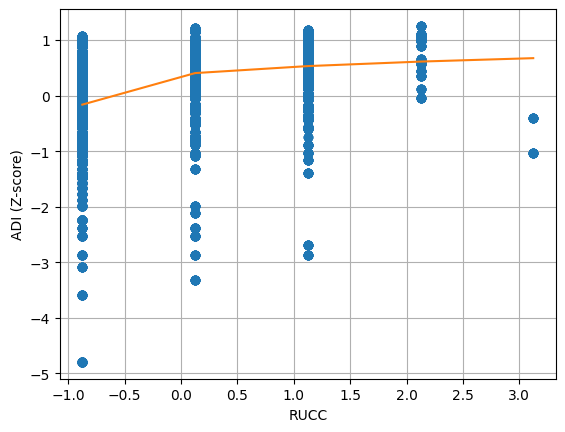

In [12]:
px = da[["RUCC_2013c", "logADINatRankZ"]]
lm = lowess(px["logADINatRankZ"], px["RUCC_2013c"])
plt.plot(px["RUCC_2013c"], px["logADINatRankZ"], "o")
plt.xlabel("RUCC")
plt.ylabel("ADI (Z-score)")
plt.plot(lm[:, 0], lm[:, 1])
plt.grid(True)

## Scaling by population size and offsets

It is natural to expect a 1-1 scaling between total population size and the number of births.  That is, all else equal we would expect two counties that differ by a factor of two in population size to differ by two in natality.  To assess this, we can make a scatterplot of the birth count versus the population size in log-space.  Under the expected 1-1 scaling, the slope of this line should be close to 1.

In [13]:
da = da.sort_values(["FIPS", "year"])
da.head()

,County,FIPS,Births,year,Population,RUCC_2013,ADI_NATRANK,logPop,logADINatRank,yearc,logPopc,RUCC_2013c,logADINatRankZ
0,"Baldwin County, AL",01003,2157.0,2011,209832,3.0,53.5,12.254062,0.152251,-4.602384,-0.332425,1.124052,0.265577
524,"Baldwin County, AL",01003,2109.0,2012,209832,3.0,53.5,12.254062,0.152251,-3.602384,-0.332425,1.124052,0.265577
1048,"Baldwin County, AL",01003,2160.0,2013,209832,3.0,53.5,12.254062,0.152251,-2.602384,-0.332425,1.124052,0.265577
1920,"Baldwin County, AL",01003,2244.0,2014,209832,3.0,53.5,12.254062,0.152251,-1.602384,-0.332425,1.124052,0.265577
2150,"Baldwin County, AL",01003,2344.0,2015,209832,3.0,53.5,12.254062,0.152251,-0.602384,-0.332425,1.124052,0.265577


1.0310470584983058

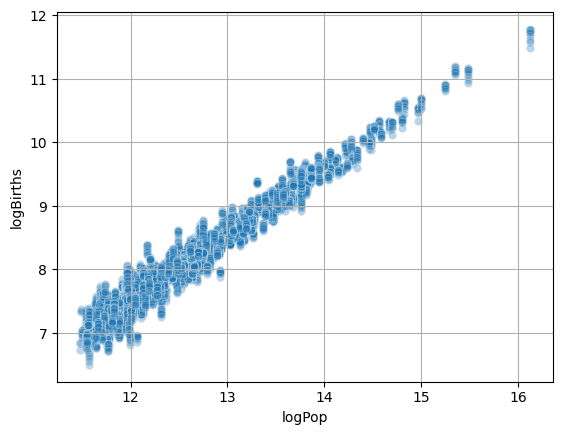

In [14]:
da["logBirths"] = np.log(da["Births"])
sns.scatterplot(da, x="logPop", y="logBirths", alpha=0.3)
plt.grid(True)
b = np.cov(da["logPop"], da["logBirths"])[0, 1] / np.var(da["logPop"])
b

## Assessing the variance structure and mean/variance relationships

Since we have 10 years of data for each county, we can treat these as replicates to estimate the mean and variance within each county (over the 10 years covered by the dataset).  This is one way for us to assess the mean/variance relationship.

In [15]:
mv = births.groupby("FIPS")["Births"].agg([np.mean, np.var])
lmv = np.log(mv)
mv

,mean,var
FIPS,,
01003,2249.400000,6699.600000
01015,1335.600000,3090.711111
01055,1190.100000,804.100000
01069,1323.714286,751.904762
01073,8650.800000,100633.288889
...,...,...
55117,1237.000000,3276.222222
55127,961.571429,6687.952381
55131,1308.200000,3390.400000


Regress log variance on log mean

In [16]:
mr = sm.OLS.from_formula("var ~ mean", lmv).fit()
print(mr.summary())

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2042.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          7.38e-192
Time:                        16:51:16   Log-Likelihood:                -735.05
No. Observations:                 580   AIC:                             1474.
Df Residuals:                     578   BIC:                             1483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4898      0.338    -16.231      0.0

Plot the log variance against the log mean.  If variance = phi * mean, then log(variance) = log(phi) + log(mean), i.e. the slope is 1 and the intercept is log(phi).  If variance = phi * mean^a then log(variance) = log(phi) + a * log(mean).

Text(0, 0.5, 'Log variance')

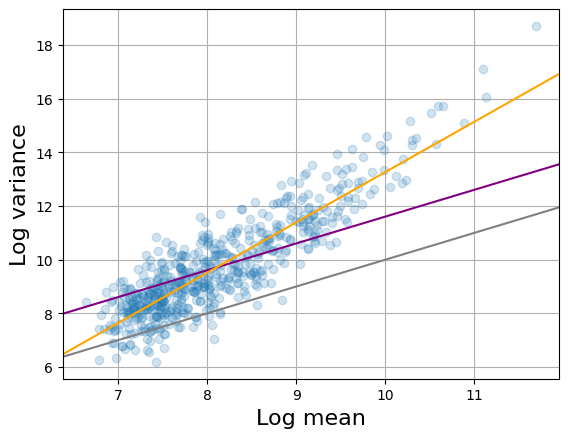

In [17]:
plt.clf()
plt.grid(True)
plt.plot(lmv["mean"], lmv["var"], "o", alpha=0.2, rasterized=True)
plt.axline((8, 8), slope=1, color="grey")
plt.axline((lmv["mean"].mean(0), lmv["var"].mean(0)), slope=1, color="purple")
plt.axline((8, mr.params[0]+8*mr.params[1]), slope=mr.params[1], color="orange")
plt.xlabel("Log mean", size=16)
plt.ylabel("Log variance", size=16)

In [22]:
da

,County,FIPS,Births,year,Population,RUCC_2013,ADI_NATRANK,logPop,logADINatRank,yearc,logPopc,RUCC_2013c,logADINatRankZ,logBirths
0,"Baldwin County, AL",01003,2157.0,2011,209832,3.0,53.5,12.254062,0.152251,-4.602384,-0.332425,1.124052,0.265577,7.676474
524,"Baldwin County, AL",01003,2109.0,2012,209832,3.0,53.5,12.254062,0.152251,-3.602384,-0.332425,1.124052,0.265577,7.653969
1048,"Baldwin County, AL",01003,2160.0,2013,209832,3.0,53.5,12.254062,0.152251,-2.602384,-0.332425,1.124052,0.265577,7.677864
1920,"Baldwin County, AL",01003,2244.0,2014,209832,3.0,53.5,12.254062,0.152251,-1.602384,-0.332425,1.124052,0.265577,7.716015
2150,"Baldwin County, AL",01003,2344.0,2015,209832,3.0,53.5,12.254062,0.152251,-0.602384,-0.332425,1.124052,0.265577,7.759614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,"Winnebago County, WI",55139,1905.0,2016,169796,3.0,71.0,12.042353,0.430716,0.397616,-0.544135,1.124052,0.751317,7.552237
3883,"Winnebago County, WI",55139,1833.0,2017,169796,3.0,71.0,12.042353,0.430716,1.397616,-0.544135,1.124052,0.751317,7.513709
4461,"Winnebago County, WI",55139,1798.0,2018,169796,3.0,71.0,12.042353,0.430716,2.397616,-0.544135,1.124052,0.751317,7.494430
5039,"Winnebago County, WI",55139,1741.0,2019,169796,3.0,71.0,12.042353,0.430716,3.397616,-0.544135,1.124052,0.751317,7.462215


## Urbanicity and time trends as predictors of natality

Below we fit a GLM, which is not appropriate since we have repeated measures on counties.  Due to the repeated measures, the uncertainty assessments (standard errors, p-values, confidence intervals, score tests) will be invalid, but the point estimates of the coefficients are still meaningful.

In [18]:
fml = "Births ~ logPop + RUCC_2013 + logADINatRankZ"
m0 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r0 = m0.fit() # Poisson
r0x = m0.fit(scale="X2") # Quasi-Poisson
r0x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5538
Model:                            GLM   Df Residuals:                     5534
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          121.58
Method:                          IRLS   Log-Likelihood:                -2950.1
Date:                Wed, 26 Mar 2025   Deviance:                   6.6212e+05
Time:                        16:58:40   Pearson chi2:                 6.73e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.1080      0.035   -146.426      0.000      -5.176      -5.040
logPop             1.0504      0.002    448.453      0.000       1.046       1.055
RUCC_2013          0.0213      0.004      5.636      0.000       0.014       0.029
logADINatRankZ     0.0383      0.002     21.218      0.000       0.035       0.042
==================================================================================
"""

Using GEE accounts for the correlated data.  After accounting for clustering by county, ADI remains significant but RUCC looses significance.

In [19]:
m1 = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Poisson(), data=da)
r1 = m1.fit() # Poisson and quasi-Poisson are the same for GEE
r1x = m1.fit(scale="X2")
r1x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 26 Mar 2025   Scale:                         121.579
Covariance type:                    robust   Time:                         17:06:48
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.1080      0.160    -32.022      0.000      -5.421      -4.795
logPop             1.0504      0.011     93.364      0.000       1.028       1.072
RUCC_2013          0.0213      0.013      1.702      0.089      -0.003       0.046
logADINatRankZ     0.0383      0.008      4.680      0.000       0.022       0.054
==============================================================================
Skew:                         -4.2744   Kurtosis:                     120.1045
Centered skew:                -8.0432   Centered kurtosis:            389.5965
==============================================================================
"""

Use log population as an offset instead of a covariate

In [20]:
m2 = sm.GEE.from_formula("Births ~ RUCC_2013 + logADINatRankZ", groups="FIPS", offset="logPop",
                         family=sm.families.Poisson(), data=da)
r2 = m2.fit(scale="X2")
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 26 Mar 2025   Scale:                         130.954
Covariance type:                    robust   Time:                         17:08:08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.3680      0.021   -205.463      0.000      -4.410      -4.326
RUCC_2013         -0.0224      0.011     -2.011      0.044      -0.044      -0.001
logADINatRankZ     0.0270      0.008      3.385      0.001       0.011       0.043
==============================================================================
Skew:                          2.4803   Kurtosis:                      42.3204
Centered skew:                -8.0432   Centered kurtosis:            389.5965
==============================================================================
"""

Below we construct a diagnostic plot for the variance structure that does not require there to be replicates  (in general there will be no replicates, and even here it is unclear whether we can treat the 10 years of data within each county as replicates).  If the variance structure is correctly specified, then the absolute Pearson residuals should have constant conditional mean with respect to the fitted values.

Text(0, 0.5, 'Absolute Pearson residual')

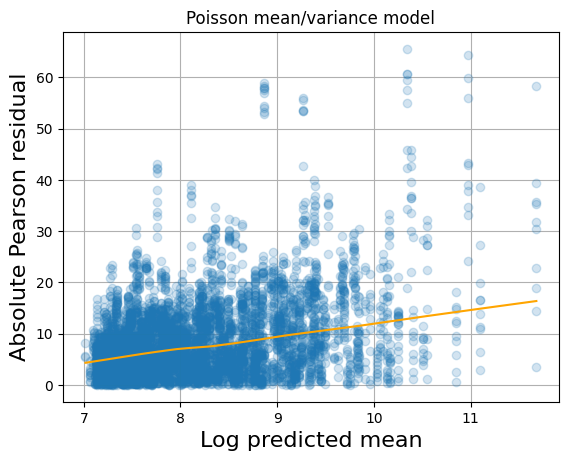

In [21]:
plt.clf()
plt.grid(True)
lfv = np.log(r2.fittedvalues).values
apr = np.abs(r2.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Poisson mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

The Poisson variance model did not fit well based on the diagnostic plot above, so we next consider a Gamma family to better match the mean/variance relationship.

In [23]:
m3 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r3 = m3.fit(scale="X2")
r3.summary()

c:\Users\16343\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 26 Mar 2025   Scale:                           0.032
Covariance type:                    robust   Time:                         17:21:03
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4496      0.015   -289.565      0.000      -4.480      -4.419
RUCC_2013      0.0059      0.008      0.731      0.465      -0.010       0.022
==============================================================================
Skew:                          3.3220   Kurtosis:                      46.3145
Centered skew:                -8.0432   Centered kurtosis:            389.5965
==============================================================================
"""

Diagnostic plot for mean/variance relationship with gamma model.

Text(0, 0.5, 'Absolute Pearson residual')

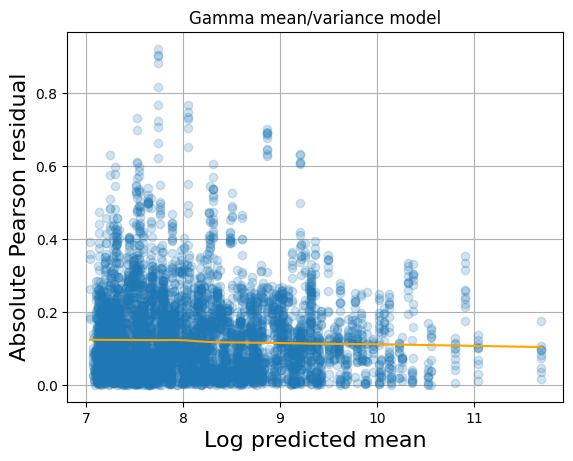

In [24]:
plt.clf()
plt.grid(True)
lfv = np.log(r3.fittedvalues).values
apr = np.abs(r3.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Now we proceed to fit and interpret some regression models.  Here we use exchangeable correlation structure in the GEE.  Since RUCC and ADI are constant within groups, the parameter estimates and standard errors are the same as with the independence model.  The first model only considers the roles of urbanicity (RUCC) and deprivation (ADI).

In [25]:
m4 = sm.GEE.from_formula("Births ~ RUCC_2013 + logADINatRankZ", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r4 = m4.fit(scale="X2")
r4.summary()

c:\Users\16343\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Wed, 26 Mar 2025   Scale:                           0.031
Covariance type:                    robust   Time:                         17:31:01
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.4227      0.016   -280.856      0.000      -4.454      -4.392
RUCC_2013         -0.0083      0.008     -0.984      0.325      -0.025       0.008
logADINatRankZ     0.0344      0.007      4.614      0.000       0.020       0.049
==============================================================================
Skew:                          5.0009   Kurtosis:                      48.8183
Centered skew:                -8.0432   Centered kurtosis:            389.5965
==============================================================================
"""

Text(0, 0.5, 'Absolute Pearson residual')

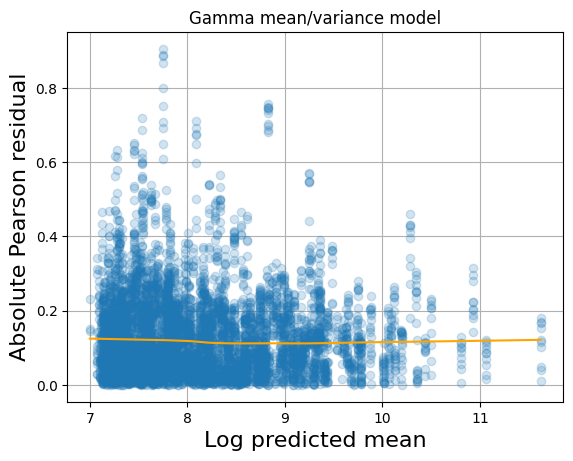

In [29]:
plt.clf()
plt.grid(True)
lfv = np.log(r4.fittedvalues).values
apr = np.abs(r4.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Now we consider the role of urbanicity as well as the potential for a linear time trend.

In [26]:
m5 = sm.GEE.from_formula("Births ~ RUCC_2013 + logADINatRankZ + year", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r5 = m5.fit(scale="X2")
r5.summary()

c:\Users\16343\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Wed, 26 Mar 2025   Scale:                           0.031
Covariance type:                    robust   Time:                         17:31:08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.0574      0.927     11.931      0.000       9.241      12.874
RUCC_2013         -0.0083      0.008     -0.985      0.325      -0.025       0.008
logADINatRankZ     0.0345      0.007      4.647      0.000       0.020       0.049
year              -0.0077      0.000    -16.729      0.000      -0.009      -0.007
==============================================================================
Skew:                          4.8764   Kurtosis:                      42.6261
Centered skew:                -8.8783   Centered kurtosis:            410.0012
==============================================================================
"""

Text(0, 0.5, 'Absolute Pearson residual')

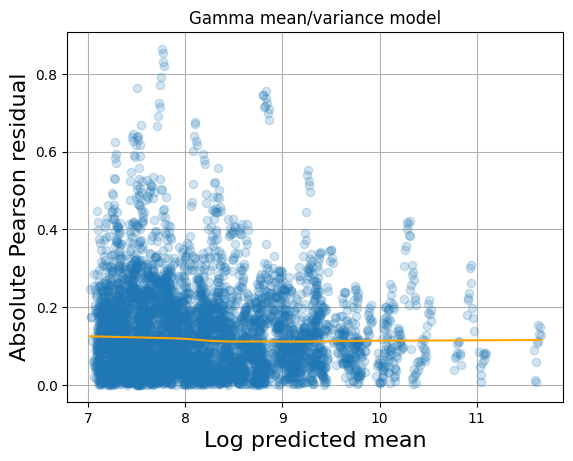

In [30]:
plt.clf()
plt.grid(True)
lfv = np.log(r5.fittedvalues).values
apr = np.abs(r5.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Now we consider the possibility that the linear time trend is different based on the level of deprivation.

In [27]:
m6 = sm.GEE.from_formula("Births ~ (logADINatRankZ + RUCC_2013c) * yearc", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r6 = m6.fit(scale="X2")
r6.summary()

c:\Users\16343\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5538
Model:                                 GEE   No. clusters:                      572
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Wed, 26 Mar 2025   Scale:                           0.031
Covariance type:                    robust   Time:                         17:31:22
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.4382      0.007   -621.042      0.000      -4.452      -4.424
logADINatRankZ           0.0346      0.007      4.653      0.000       0.020       0.049
RUCC_2013c              -0.0081      0.008     -0.959      0.338      -0.025       0.008
yearc                   -0.0077      0.000    -17.143      0.000      -0.009      -0.007
logADINatRankZ:yearc     0.0011      0.000      2.182      0.029       0.000       0.002
RUCC_2013c:yearc        -0.0032      0.001     -6.010      0.000      -0.004      -0.002
==============================================================================
Skew:                          4.8786   Kurtosis:                      42.7490
Centered skew:                -8.8106   Centered kurtosis:            404.3912
==============================================================================
"""

Score tests comparing pairs of nested models:

In [28]:
print(r5.model.compare_score_test(r4))
print(r6.model.compare_score_test(r5))

{'statistic': 177.05951675328342, 'df': 1, 'p-value': 0.0}
{'statistic': 29.776334630453395, 'df': 3, 'p-value': 1.5379403626170074e-06}


## Principal Components Regression

We begin by double centering the demographic data.

In [ ]:
demogx = np.asarray(demog)
demogx = np.log(1 + demogx)
demogx -= demogx.mean()
demogx -= demogx.mean(0)
demogx -= demogx.mean(1)[:, None]
demog

Get factors (principal components) from the demographic data.

In [ ]:
u, s, vt = np.linalg.svd(demogx, 0)
v = vt.T

Convert the coefficients back to the original coordinates

In [ ]:
def convert_coef(c, npc):
    return np.dot(v[:, 0:npc], c/s[0:npc])

Put the demographic factors into a dataframe

In [ ]:
m = {("pc%02d" % k) : u[:, k] for k in range(100)}
m["FIPS"] = demog.index
demog_f = pd.DataFrame(m)

Merge demographic information into the births data

In [ ]:
da = pd.merge(da, demog_f, on="FIPS", how="left")

Include this number of factors in subsequent models

In [ ]:
npc = 10

A GLM, not appropriate since we have repeated measures on counties

In [ ]:
fml = "Births ~ (logPopc + RUCC_2013c) * yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
m7 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r7 = m7.fit(scale="X2")
r7.summary()

GEE accounts for the correlated data

In [ ]:
m8 = sm.GEE.from_formula(fml, groups="FIPS",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r8 = m8.fit(scale="X2")
r8.summary()

Use log population as an offset instead of a covariate

In [ ]:
fml = "Births ~ " + " + ".join(["pc%02d" % j for j in range(npc)])
m9 = sm.GEE.from_formula(fml, groups="FIPS", offset="logPop",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r9 = m9.fit(scale="X2")
r9.summary()

Restructure the coefficients so that the age bands are in the columns.

In [ ]:
def restructure(c):
    ii = pd.MultiIndex.from_tuples(na)
    c = pd.Series(c, index=ii)
    c = c.unstack()
    return c

This function fits a Gamma GLM to the data using 'npc' principal components as explanatory variables (using GEE to account for non-independence), then converts the coefficients back to the original variables.

In [ ]:
def fitmodel(npc):
    # A GEE using log population as an offset
    fml = "Births ~ 1" if npc == 0 else "Births ~ RUCC_2013c*yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
    m = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Gamma(link=sm.families.links.log()),
                            offset=da["logPop"], data=da)
    r = m.fit(scale="X2")

    # Convert the coefficients back to the original coordinates
    c = convert_coef(r.params[4:], npc)

    # Restructure the coefficients so that the age bands are
    # in the columns.
    c = restructure(c)

    return c, m, r

Plot styling information

In [ ]:
colors = {"A": "purple", "B": "orange", "N": "lime", "W": "red"}
lt = {"F": "-", "M": ":"}
sym = {"H": "s", "N": "o"}
ages = range(0, 20)

Fit models with these numbers of PCs.

In [ ]:
pcs = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
models = []
for npc in pcs:

    c, m, r = fitmodel(npc)
    models.append((m, r))

    plt.clf()
    plt.figure(figsize=(9, 7))
    ax = plt.axes([0.14, 0.18, 0.7, 0.75])
    ax.grid(True)
    for i in range(c.shape[0]):
        a = c.index[i]
        la = "/".join(a)
        ax.plot(ages, c.iloc[i, :], lt[a[2]] + sym[a[1]], color=colors[a[0]],
                label=la)

    # Setup the horizontal axis labels
    ax.set_xticks(ages)
    ax.set_xticklabels(age_groups)
    for x in plt.gca().get_xticklabels():
        x.set_rotation(-90)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.xlabel("Age group", size=17)
    plt.ylabel("Coefficient", size=17)
    plt.title("%d factors" % npc)
    plt.show()

Use score tests to get a sense of the number of PC factors to include; also consider the PVEs calculated above.

In [ ]:
for k in range(10):
    st = models[k+1][0].compare_score_test(models[k][1])
    print("%d versus %d: p=%f" % (pcs[k+1], pcs[k], st["p-value"]))